# Transferability of models trained with weighted-SOAP to larger system sizes: Bulk-Cu

This notebook will demonstrate the use of a NN model trained with weighted-SOAP descriptors can be used for larger periodic cells. 

Importing required packages. For this demonstration, let's build NNs with pyTorch and train them on GPU (M1 Mac).

In [5]:
import torch
import math
import numpy as np
import dscribe
from ase.build import molecule
from dscribe.descriptors import SOAP
from ase.io import read, write
from ase import Atom, Atoms
import time
import os
import sys
import pickle
from ase.io.cube import read_cube, write_cube
from sklearn.metrics import explained_variance_score, mean_squared_error
import py3Dmol
sys.path.append('deepcdp/')
from deepcdp import deepcdp
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import sklearn.metrics as skmetrics
from sklearn.neural_network import MLPRegressor
import gc
import zipfile
import pandas as pd
from tqdm import tqdm
from ase.build import bulk
from ase.visualize.plot import plot_atoms

import datetime
import matplotlib.pyplot as plt
import random
import torch.utils.data as utils_data
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout

import warnings
warnings.filterwarnings('ignore')

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Device: ", device)

# This ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# This ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

Device:  mps
True
True


We will train our models with the small Cu FCC cell containing two atoms. 

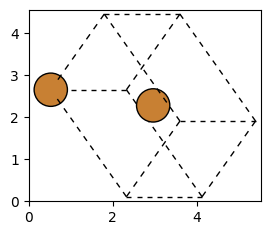

In [7]:
# We will use ase's bulk function. Set up an orthorhombic cell. 
copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
# view(copper_ortho, viewer='x3d') # uncomment this if you want to have an interactive view
fig, ax = plt.subplots(figsize=(3,3))
plot_atoms(copper_ortho, ax, radii=0.3, rotation=('45x,45y,0z'))
plt.show()

Generating the SOAP function with DScribe. Our SOAP is coded to be periodic along all three dimensions.

In [8]:
rcut = 2.54*3 # Local cut off
nmax = 8 # max number of radial basis functions
lmax = 8 # maximum degree of spherical harmonics

copper_ortho = bulk('Cu', 'fcc', a=3.6, orthorhombic=True)
print('Periodic = ',copper_ortho.get_pbc()) # checking for periodicity in ase

copper_soap_W = SOAP( # W = with weighting
    species=[29],
    rcut=rcut,
    nmax=nmax,
    lmax=nmax,
    sigma=1,
    periodic=True,
    sparse=False,
    weighting={"function":"poly","r0":2,"c":2,"m":2}
)

Periodic =  [ True  True  True]


Loading data.

In [152]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/bulk-Cu/'
datafilename = 'Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']

data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']

cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP_noW=deepcdp(copper_soap_noW)

# generates a box of points. Be mindful of the gamma value used.
CDP_noW.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP_noW.generate_cube_data(data_files_sub,cubefile,sampleSubs)


[145, 67, 450, 387, 220, 200, 82, 0, 300, 2, 130, 259]
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_145.cube
SOAP is of dimension: (5175, 324)
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_82.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_300.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_450.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_259.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_130.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_200.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_67.cube


(array([[ 0.00247416, -0.03517585,  0.06287117, ...,  0.0858599 ,
          0.02634343,  0.0137854 ],
        [ 0.00431003, -0.03941039,  0.10080376, ...,  0.55318279,
         -0.29479425,  0.20356311],
        [ 0.00690025, -0.03971601,  0.14939078, ...,  1.37703836,
         -0.9852263 ,  0.75403359],
        ...,
        [ 0.00210297, -0.03289138,  0.04279443, ...,  0.61425183,
         -0.57328395,  0.61951147],
        [ 0.00207209, -0.03313783,  0.04717096, ...,  0.24477213,
         -0.24700859,  0.33523321],
        [ 0.0024094 , -0.03485584,  0.05764187, ...,  0.0522228 ,
         -0.03411272,  0.11864608]]),
 array([1.7777 , 0.5902 , 0.20032, ..., 1.4553 , 1.8612 , 1.6637 ]))

The CDP_noW object stores the training X (SOAP) and Y (densities). 

In [155]:
CDP_noW.trainX.shape, int(CDP_noW.trainX.shape[0]/6), CDP_noW.trainY.shape, 

((51750, 324), 8625, (51750,))

There are a total of 31050 points samples from these 6 images. Each image contains 5175 points. The SOAPs correspond to 324 features. Let's use this data to train a model. 

In [154]:
# training a model
start = time.time()
model_Cu_noW = MLPRegressor(hidden_layer_sizes=(300,300,300),
                           random_state=1,
                           max_iter=300, 
                           shuffle=True,
                          batch_size=500,
                         ).fit(CDP_noW.trainX, 
                               CDP_noW.trainY) 
end = time.time()
print("Training: ", (end - start), " seconds.")

Training:  114.30640006065369  seconds.


In [159]:
file_name = 'sample-models/bulk-cu/cu_noW.sav'
pickle.dump(model_Cu_noW, open(file_name,'wb'))

In [425]:
# Testing 0 Cu structure
test_cube_path = 'data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = copper_soap_W.create(ase_atoms_test, positions=CDP_noW.box)
rho_pred = model_Cu_noW.predict(soap_test)

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')

Prediction time:  2.8246068954467773  seconds.
R2 value: 0.62
MSE value: 0.04778


For a sample cube file, we get a prediction R2 value of 0.62.

In [426]:
out=open('example/predictions/bulk-cu/pred-0_noW.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP_noW.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP_noW.box[0])

In [427]:
cu_cube_predict=open('example/predictions/bulk-cu/pred-0_noW.cube').read()
cu_cube_dft=open(test_cube_path).read()
CDP_noW.cube2xyz(test_cube_path,'example/structures/bulk-cu/cu-0.xyz')
cu_xyz=open('example/structures/bulk-cu/cu-0.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_cube_predict,'cube',{'isoval': 0.3,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(cu_cube_dft,'cube',{'isoval': 0.3,"color":'grey','opacity':1,'wireframe':True})
# xyzview.addModel(cu_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Comparing the difference between the two electron density predictions

In [428]:
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/bulk-cu/error-0_noW.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP_noW.box[0])

In [429]:
cu_error_predict=open('example/predictions/bulk-cu/error-0_noW.cube').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_error_predict,'cube',{'isoval': 0.3,"color":'blue','opacity':1,'wireframe':False})
# xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

It is obvious that the model does not perform well. Let's try to integrate the densities along the z axis and then plot 2D contours.

In [430]:
# fixing vmin and vmax
vmax = 11
vmin = 3

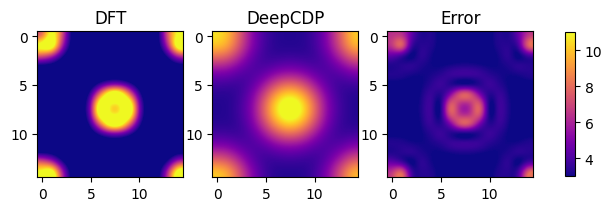

In [435]:
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=3, vmax=11)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
# plt.savefig('Images/Cu-soap-without-weights.png',dpi=600,bbox_inches="tight",)

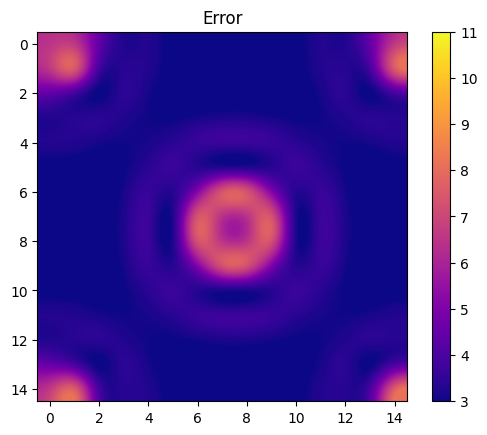

In [282]:
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36',vmin=vmin, vmax=vmax)
plt.title('Error')
plt.colorbar()
plt.show()

## Training model using weighting function

Let's now generate a model using the weighted-SOAP function for Cu. 

In [141]:
# Use the 6 DFT data points.
subsample=10

# Path of the file and filename prefix
datapath = 'data/bulk-Cu/'
datafilename = 'Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_' 
all_files = os.listdir(f'{datapath}')
idxList=[int(x.split('.cube')[0].split('_')[-1]) 
         for x in data_files if x.split('.')[-1] == 'cube']

data_files =[x for x in all_files 
               if x.split('.')[-1] == 'cube']

cubefile = lambda x:f'{datapath}{x}' # creating a lambda function
print(idxList)
# generating an object of type deepcdp (imported)
CDP_W=deepcdp(copper_soap_W)

# generates a box of points. Be mindful of the gamma value used.
CDP_W.create_box(sample_cubeFile=datapath+data_files[0], gamma=90)

totalfiles=int(os.popen(f'ls {datapath} | wc -l').read().split('\n')[0])

# useing ase's read_cube to read a sample cube file
dicttest=read_cube(open(datapath+data_files[0]))
sampleSubs=dicttest['atoms']
sampleSubs.set_pbc((True, True, True))

# randomly picking snapshots for training
data_files_sub = random.sample(data_files, k=subsample)

# generating final dataset
CDP_W.generate_cube_data(data_files_sub,cubefile,sampleSubs)


[145, 67, 450, 387, 220, 200, 82, 0, 300, 2, 130, 259]
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_259.cube
SOAP is of dimension: (5175, 324)
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_200.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_2.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_220.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_450.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_67.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_130.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_82.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube
Read file: data/bulk-Cu/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_145.cube


(array([[3.54132154e-02, 2.46856273e-01, 6.31376090e-01, ...,
         5.07052271e-14, 7.54875900e-14, 1.12382422e-13],
        [3.57500822e-02, 2.49187463e-01, 6.37091078e-01, ...,
         4.69474209e-14, 6.98716806e-14, 1.03989775e-13],
        [2.89146835e-02, 2.01849258e-01, 5.20584341e-01, ...,
         2.18894813e-13, 3.28034883e-13, 4.91591751e-13],
        ...,
        [6.62404058e-02, 4.59620815e-01, 1.14608152e+00, ...,
         1.20459403e-12, 3.20712639e-12, 8.53869616e-12],
        [7.30457719e-02, 5.06469837e-01, 1.25799722e+00, ...,
         6.92156773e-17, 1.99921145e-16, 5.77911558e-16],
        [6.43730933e-02, 4.46759149e-01, 1.11527719e+00, ...,
         1.41658095e-17, 2.06882527e-17, 3.02138610e-17]]),
 array([0.88537, 0.90186, 0.66121, ..., 2.5005 , 2.6162 , 2.3735 ]))

In [142]:
# training a model
start = time.time()
model_Cu_W = MLPRegressor(hidden_layer_sizes=(300,300,300),
                           random_state=1,
                           max_iter=300, 
                           shuffle=True,
                          batch_size=500,
                         ).fit(CDP_W.trainX, 
                               CDP_W.trainY) 
end = time.time()
print("Training: ", (end - start), " seconds.")

Training:  87.03382921218872  seconds.


In [162]:
file_name = 'sample-models/bulk-cu/cu_W.sav'
pickle.dump(model_Cu_W, open(file_name,'wb'))

In [373]:
# Testing 0 Cu structure
test_cube_path = 'data/bulk-Cu/train/Cu-fcc-ELENTRON-DEN-ELECTRON_DENSITY-1_0.cube'
test_cube = read_cube(open(test_cube_path))
ase_atoms_test = test_cube['atoms']
ase_atoms_test.set_pbc((True, True, True))
pos_atoms_test = ase_atoms_test.get_positions()
rho_test = test_cube['data']
rho_test = rho_test.ravel().reshape(-1,1)

start = time.time()
soap_test = copper_soap_W.create(ase_atoms_test, positions=CDP_W.box)
rho_pred = model_Cu_W.predict(soap_test)

end = time.time()
print("Prediction time: ", (end - start), " seconds.")
print(f'R2 value: {skmetrics.r2_score(rho_test,rho_pred):1.2f}')
print(f'MSE value: {skmetrics.mean_squared_error(rho_test,rho_pred):1.5f}')


Prediction time:  3.6644411087036133  seconds.
R2 value: 0.98
MSE value: 0.00248


In [374]:
out=open('example/predictions/bulk-cu/pred-0.cube','w+')
rho_test_resp = rho_pred.reshape(*CDP_W.bounds)
write_cube(out,ase_atoms_test,rho_test_resp,origin=CDP_W.box[0])

In [375]:
cu_cube_predict=open('example/predictions/bulk-cu/pred-0.cube').read()
cu_cube_dft=open(test_cube_path).read()
CDP_W.cube2xyz(test_cube_path,'example/structures/bulk-cu/cu-0.xyz')
cu_xyz=open('example/structures/bulk-cu/cu-0.xyz').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_cube_predict,'cube',{'isoval': 0.3,"color":'red','opacity':1,'wireframe':True})
xyzview.addVolumetricData(cu_cube_dft,'cube',{'isoval': 0.3,"color":'grey','opacity':1,'wireframe':True})
# xyzview.addModel(cu_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [376]:
rho_test_resp.shape
rho_test = test_cube['data']
error = np.abs(rho_test - rho_test_resp)
out=open('example/predictions/bulk-cu/error-0_W.cube','w+')
write_cube(out,ase_atoms_test,error,origin=CDP_noW.box[0])

In [377]:
cu_error_predict=open('example/predictions/bulk-cu/error-0_W.cube').read()
xyzview = py3Dmol.view(width=400,height=400)
xyzview.addVolumetricData(cu_error_predict,'cube',{'isoval': 0.3,"color":'blue','opacity':1,'wireframe':False})
# xyzview.addModel(water_xyz,'xyz')
xyzview.setStyle({'stick':{}})
xyzview.zoomTo()
xyzview.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

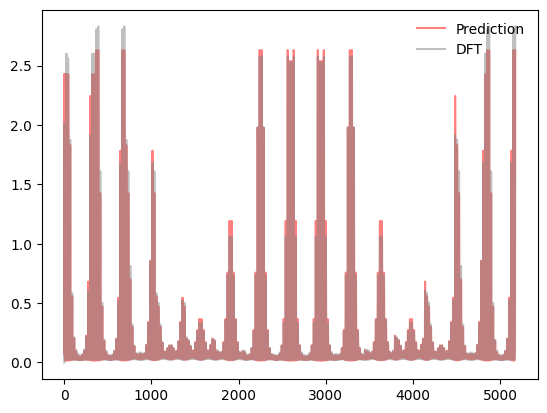

In [378]:
plt.plot(rho_test_resp.flatten(), color='red',label='Prediction',alpha=0.5)
plt.plot(rho_test.flatten(), color='grey', label='DFT',alpha=0.5)
plt.legend(frameon=False)
plt.show()

These prediction errors are tiny compared to the non weighted case.  

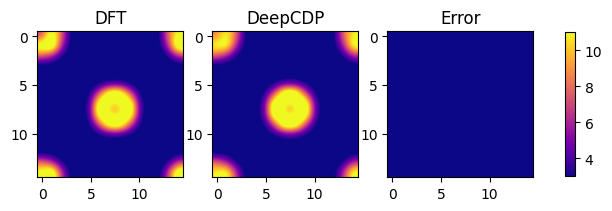

In [380]:
plt.subplot(131)
plt.imshow(np.trapz(rho_test, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DFT')
plt.subplot(132)
plt.imshow(np.trapz(rho_test_resp, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('DeepCDP')
plt.subplot(133)
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36', vmin=vmin, vmax=vmax)
plt.title('Error')
plt.subplots_adjust(bottom=0.0, right=0.9, top=0.9)
cax = plt.axes([0.95, 0.3, 0.015, 0.3])
plt.colorbar(cax=cax)
plt.savefig('Images/Cu-soap-with-weights.png',dpi=600,bbox_inches="tight",)

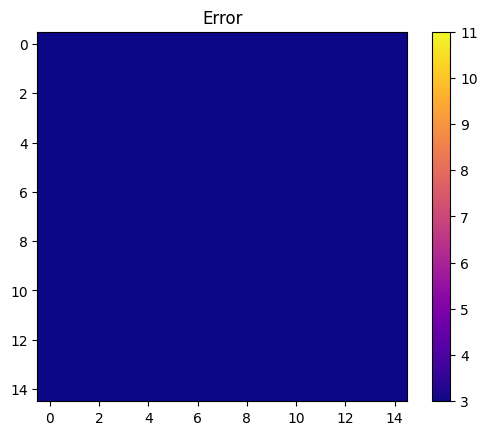

In [290]:
plt.imshow(np.trapz(error, axis=2 ), cmap='plasma',
           interpolation ='spline36',vmin=vmin, vmax=vmax)
plt.title('Error')
plt.colorbar()
plt.show()

In [392]:
vectors = np.array([[1, 2, 3], [1, 3, 4], [11, 22, 43]])

# Compute the pairwise distances between the vectors
distances = skmetrics.euclidean_distances(vectors)

# Compute the minimum distance between each pair of vectors
min_distances = np.min(distances[np.nonzero(distances)])

print(min_distances)

# Compute the sensitivity score
sensitivity = min_distances / np.max(vectors)

print("Sensitivity score:", sensitivity)

1.4142135623730951
Sensitivity score: 0.03288868749704872
